/Users/audide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/Users/audide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


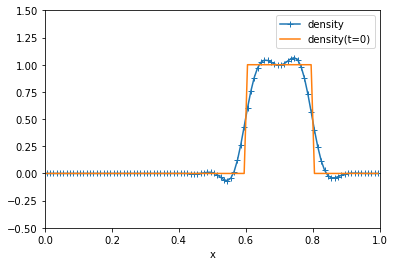

In [1]:
import numpy as np
from matplotlib import pyplot as plt


def set_params():

    global xmin, xmax, c, t_end, nx, cfl, n_ghost

    xmin=0.0
    xmax=1.0
    c = 1.0
    t_end = 1.0

    nx = 100
    cfl = 0.1
    n_ghost = 3

def set_init():

    global time, dx, dt, js, je, nt, x, xb, u, u_init, flux
    time = 0.0
    dx = (xmax-xmin)/(nx)
    dt = cfl*dx/abs(c)

    js = n_ghost
    je = nx + n_ghost

    nt = int(round(t_end/dt))
    if(nt*dt < t_end): nt=nt+1

    x = np.linspace(xmin-(n_ghost-0.5)*dx,xmax+(n_ghost-0.5)*dx,nx+2*n_ghost)
    xb = np.linspace(xmin-(n_ghost-1)*dx,xmax+(n_ghost)*dx,nx+2*n_ghost)

    sigma = 0.05
    u = 0.0*np.exp(-(x-0.3)**2/(2*sigma**2))

    for j in range(js,je+1):
        if(0.5 < x[j]): u[j] = 0.0
        if((0.6 <= x[j]) and (x[j]<=0.8)):
            u[j]=1.0
        elif(0.8<x[j]):
            u[j]=0.0

    apply_bc(u)

    u_init = u.copy()
    flux = np.zeros_like(u)

def apply_bc(u):
    for j in range(0,n_ghost):
        u[je+j]=u[js+j]
        u[j]=u[je-n_ghost+j]

def plot_it():
    plt.plot(x[js:je], u[js:je], "-+",label="density");
    plt.plot(x[js:je], u_init[js:je], label="density(t=0)");
    plt.xlim(0.0,1.0); plt.ylim(-0.5,1.5)
    plt.xlabel("x")
    plt.legend(prop={'size': 10})
    plt.show()

def advance():

    global time, u, t_end, dt, u_old, t_steps, x_steps #added
    
    t_steps = 0 #added
    
    while (time < t_end):
        
        dt1 = min(dt, t_end - time)
        
        u_old = u.copy()
        f_step1(u,dt1)
        f_step1(u,dt1)
        u=3./4.*u_old + 1./4.*u
        f_step1(u,dt1)
        u=1./3.*u_old + 2./3.*u

        time = time + dt1
        
        x_steps = 0
        
        for j in range(js,je+1):            #added 
            inputs.append([time, x[j]])     #added
            outputs.append(u[j])            #added
            uu[t_steps,int(x_steps)] = u[j] #added
            x_steps = x_steps + 1           #added
            
        t_steps = t_steps + 1               #added   

def f_step1(u,dt):

    global xb

    ubL = np.zeros_like(u)
    ubR = np.zeros_like(u)

    ubL[js-1:je] = ((1.0-1.0/6.)*u[js-1:je]
                           -(1./4.-1./12.0)*u[js-1-1:je-1]
                           +(1./4.+1./12.)*u[js-1+1:je+1])

    ubR[js-1:je] = ((1.0-1.0/6.)*u[js-1+1:je+1]
                           -(1./4.-1./12.0)*u[js-1+2:je+2]
                           +(1./4.+1./12.)*u[js-1:je])

    flux_common(flux, ubL, ubR)

    u[js:je] = u[js:je] - dt/dx*(flux[js:je] - flux[js-1:je-1])

    apply_bc(u)
    

    
def flux_func(ub):
    global c
    r = np.zeros_like(ub)    #added
    r[js-1:je] = (ub[js-1-1:je-1]-ub[js-1-2:je-2])/(ub[js-1:je]-ub[js-1-1:je-1]) #added
    
    phi_r = np.zeros_like(r) #added
    phi_r[js-1:je] = np.minimum(phi_r[js-1:je],1)  #added
    phi_r[js-1:je] = np.maximum(phi_r[js-1:je],0)  #added
    
    Flux_difference = np.zeros_like(ub)            #added
    Flux_difference[js-1:je] = ub[js-1:je] - ub[js-1-1:je-1]   #added
    
    return c*ub + 0.5*c*((dx-c*dt)/dx)*phi_r*Flux_difference   #added


def flux_common(flux, ubL, ubR):

    flux_L = flux_func(ubL)
    flux_R = flux_func(ubR)

    flux[js-1:je] = (1/2) * (flux_L[js-1:je] + flux_R[js-1:je]) \
                      - (np.abs(c)/2)*(ubR[js-1:je]-ubL[js-1:je])

set_params()
set_init()

t_steps = int(t_end/dt) #added
x_steps = je-js+1       #added
xx = np.linspace(x[js], x[je+1], int(x_steps)) #added
tt = np.linspace(0, t_end, t_steps)            #added
uu = np.zeros((t_steps, int(x_steps)))         #added
inputs = []    #added
outputs = []   #added


advance()
plot_it()